# Continued EDA/Modelling/Predictions

In [525]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from PredMetric.PMetrics import PredictionMetrics

plt.style.use('dark_background')

In [526]:
train = pd.read_csv("./interim_datasets/train_interim.csv")
kaggle = pd.read_csv("./interim_datasets/kaggle_interim.csv")

In [527]:
nominal_cols = ["MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood","Condition 1","Condition 2","Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", "Misc Feature"]
ordinal_cols = ["Lot Shape", "Utilities", "Land Slope", "Overall Qual", "Overall Cond", "Exter Qual", "Exter Cond", "Bsmt Qual", "Bsmt Cond", "Bsmt Exposure", "BsmtFin Type 1", "BsmtFin Type 2", "Heating QC", "Electrical", "Kitchen Qual", "Functional", "Fireplace Qu", "Garage Finish", "Garage Qual", "Garage Cond", "Paved Drive", "Pool QC", "Fence"]
continuous_cols = ["Lot Frontage", "Lot Area", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Gr Liv Area", "Garage Area", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"]
discrete_cols = ["Year Built", "Year Remod/Add", "Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath", "Bedroom abvgr", "Kitchen abvgr", "totrms abvgrd", "Fireplaces", "Garage Yr Blt", "Garage Cars", "Mo Sold" ,"Yr Sold"]

In [528]:
def convert(x):
    return x.lower().replace(" ", "_")

nominal_con_cols = [convert(x) for x in nominal_cols]
ordinal_con_cols = {convert(x):{} for x in ordinal_cols}
continuous_con_cols = [convert(x) for x in continuous_cols]
discrete_con_cols = [convert(x) for x in discrete_cols]

In [529]:
all_columns = list(train.filter(regex="dum")) + \
              list(ordinal_con_cols.keys()) + continuous_con_cols + \
              list(train.filter(regex="bin")) + \
              ["totrms_abvgrd", "fireplaces", "garage_yr_blt", "garage_cars", "mo_sold", "yr_sold", "full_bath"]

In [530]:
#Remove outliers for Lot Frontage and Gr Liv Area
new_train = train.drop([960, 1885, 471,694]) 
new_train[new_train['garage_yr_blt']>2020]['garage_yr_blt']

1699    2207.0
Name: garage_yr_blt, dtype: float64

In [531]:
new_train.at[1699, ["garage_yr_blt"]] = 2007

In [532]:
new_train[new_train['garage_yr_blt']>2020]['garage_yr_blt']

Series([], Name: garage_yr_blt, dtype: float64)

In [533]:
###Interaction Terms:

In [534]:
new_train["new_bath_beds"] = new_train["bin_total_baths"] * new_train["bedroom_abvgr"]

In [535]:
new_train["new_bath_beds_kit"] = new_train["new_bath_beds"] * new_train["kitchen_abvgr"]

In [536]:
new_train["new_house_age"] = new_train["yr_sold"]  - new_train["year_built"]

In [537]:
new_train["new_age_fireplace"] = new_train["new_house_age"] * new_train["fireplaces"] 

In [538]:
new_train["new_yr_sold_ordinal"] = new_train["yr_sold"]  - new_train["yr_sold"].min()

In [539]:
new_train["new_yr_sold_ord_age"] = new_train["new_yr_sold_ordinal"]  * new_train["new_house_age"]

In [540]:
new_train["new_yr_blt_remod_sold"] = (new_train["year_built"]/new_train["year_remod/add"]/new_train["yr_sold"]) * 100_000

In [541]:
new_train["new_lot_frontage_area_yso"]  = new_train["lot_frontage"] * new_train["lot_area"] * new_train["new_yr_sold_ordinal"]

In [542]:
list(new_train.filter(regex="new").columns)

['new_bath_beds',
 'new_bath_beds_kit',
 'new_house_age',
 'new_age_fireplace',
 'new_yr_sold_ordinal',
 'new_yr_sold_ord_age',
 'new_yr_blt_remod_sold',
 'new_lot_frontage_area_yso']

In [543]:
###Combined all the relevant features so far

In [544]:
revised_features = ['bin_total_baths',
 'bin_year_built',
 'bsmt_cond',
 'bsmt_exposure',
 'bsmt_qual',
 'bsmtfin_sf_1',
 'dumcon_posa.1',
 'dumext_brkface',
 'dummis_elev',
 'dummis_tenc',
 'dumms__20',
 'dumms__60',
 'dumnei_grnhill',
 'dumnei_noridge',
 'dumnei_nridght',
 'dumnei_nwames',
 'dumnei_stonebr',
 'dumroo_wdshngl',
 'exter_qual',
 'functional',
 'kitchen_qual',
 'lot_area',
 'mas_vnr_area',
 'overall_qual',
 'screen_porch',
 'gr_liv_area', 
 '1st_flr_sf', 
 'garage_area', 
 'total_bsmt_sf',
 'new_bath_beds',
 'new_house_age',
 'new_yr_sold_ordinal',
 'new_yr_sold_ord_age']

In [545]:
##creating a poly for all the above selected features
poly_revised_features = ['overall_qual overall_qual',
 'garage_area overall_qual',
 'gr_liv_area kitchen_qual',
 '1st_flr_sf overall_qual',
 'overall_qual total_bsmt_sf',
 'bin_total_baths bsmt_qual',
 '1st_flr_sf total_bsmt_sf',
 '1st_flr_sf dumnei_nridght',
 'gr_liv_area lot_area',
 'bsmt_cond bsmtfin_sf_1',
 'bsmt_exposure lot_area',
 '1st_flr_sf lot_area',
 'dumms__60 lot_area',
 'dumms__60 functional',
 'bsmt_exposure dumms__20',
 'bsmtfin_sf_1 dumms__20',
 'dumnei_noridge lot_area',
 'functional functional',
 'dumms__20 functional',
 'dumext_brkface overall_qual',
 'dumnei_grnhill lot_area',
 'dummis_tenc screen_porch',
 'dummis_tenc overall_qual',
 'dummis_tenc functional',
 'dummis_tenc kitchen_qual',
 'dummis_tenc dumnei_nwames',
 'dummis_tenc dumms__60',
 'dummis_tenc dummis_tenc',
 'bsmt_qual dummis_tenc',
 'bin_year_built dummis_tenc',
 'dummis_tenc garage_area',
 'bin_total_baths dummis_tenc',
 'dummis_tenc gr_liv_area',
 'dummis_tenc total_bsmt_sf',
 '1st_flr_sf dummis_tenc',
 'bsmtfin_sf_1 dummis_tenc',
 'dummis_tenc exter_qual',
 'bsmt_cond dummis_tenc',
 'dummis_tenc lot_area',
 'dummis_tenc mas_vnr_area',
 'bedroom_abvgr fireplaces',
 'half_bath half_bath',
 'low_qual_fin_sf open_porch_sf',
 '1st_flr_sf bedroom_abvgr',
 'kitchen_abvgr totrms_abvgrd',
 'bsmt_unf_sf garage_yr_blt',
 'bsmtfin_sf_1 year_built',
 'total_bsmt_sf yr_sold',
 'total_bsmt_sf year_remod/add',
 'gr_liv_area year_remod/add',
 'bedroom_abvgr garage_cars',
 'total_bsmt_sf year_built',
 'lot_area total_bsmt_sf',
 'bedroom_abvgr totrms_abvgrd']

In [546]:
make_poly = []
for p in poly_revised_features:
    cols = p.split(" ")
    make_poly.append([cols[0], cols[1], p])

In [547]:
for cols in make_poly:
    new_train[cols[2]] = new_train[cols[0]] * new_train[cols[1]]

In [548]:
new_train.shape

(2047, 317)

In [571]:
combined_features = revised_features + poly_revised_features
new_train[combined_features].shape

(2047, 87)

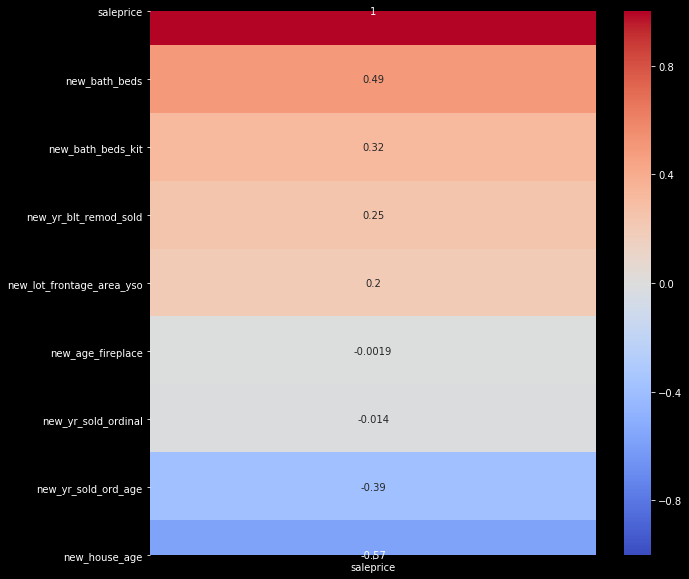

In [575]:
nf = list(new_train.filter(regex="new").columns) + ["saleprice"]
plt.figure(figsize=(10,10))
sns.heatmap(new_train[nf].corr()[['saleprice']].sort_values(by='saleprice', ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

In [550]:
# y = new_train["saleprice"].map(np.log)
# X = new_train[combined_features]
# ols_X = sm.add_constant(X)
# model_ols = sm.OLS(y,ols_X).fit()
# m = model_ols.summary()

In [551]:
# re_revised_features = []
# for i in range(1, len(m.tables[1].data)):
#     if float(m.tables[1].data[i][4]) <= 0.05:
#         re_revised_features.append(m.tables[1].data[i][0])

# re_revised_features.remove("const")
# X = new_train[re_revised_features]
# ols_X = sm.add_constant(X)
# model_ols = sm.OLS(y,ols_X).fit()
# m = model_ols.summary()
# model_ols.summary()

In [552]:
X = new_train[combined_features]
y = new_train["saleprice"].map(np.log)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [553]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_train = np.exp(y_train)
y_test = np.exp(y_test)

In [554]:
pm = PredictionMetrics(lr, X_train, X_test, y_train, y_test, True)
pm.metric_df

,Scores,Train,Test,Result,Percent
0,lr.score,-5.2999,-5.07974,Train < Test,4.33402
1,r2_score,0.932637,0.933214,Train < Test,-0.0618238
2,mean cross_val_score,0.919932,0.905155,Train > Test,1.63248
3,mean_squared_error,4.25629e+08,4.09398e+08,Train > Test,3.96471
4,root mean squared error,20630.8,20233.6,Train > Test,1.96308
5,residual mean,14455.7,14349.3,Train > Test,0.741567
6,cross_val_score,"[0.908, 0.936, 0.905, 0.919, 0.931]","[0.924, 0.93, 0.85, 0.902, 0.919]",NaN,NaN


In [555]:
ols_X = sm.add_constant(X)
model_ols = sm.OLS(y,ols_X).fit()
model_ols.summary().tables[0]

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Dep. Variable:,saleprice,R-squared:,0.911
Model:,OLS,Adj. R-squared:,0.908
Method:,Least Squares,F-statistic:,303.9
Date:,"Thu, 16 Jan 2020",Prob (F-statistic):,0.00
Time:,12:50:59,Log-Likelihood:,1395.0
No. Observations:,2047,AIC:,-2654.
Df Residuals:,1979,BIC:,-2272.
Df Model:,67,,
Covariance Type:,nonrobust,,


In [556]:
new_train["salesprice_hat"] = np.exp(lr.predict(X))
new_train["salesprice_hat"].describe()

count      2047.000000
mean     181250.679144
std       76527.737073
min       21212.736519
25%      127891.368590
50%      162072.187295
75%      215955.539329
max      553349.508408
Name: salesprice_hat, dtype: float64

In [557]:
new_train["residuals"] = abs(new_train["saleprice"] - new_train["salesprice_hat"])
new_train.loc[new_train["residuals"] < 10_000, ["saleprice", "salesprice_hat", "residuals"]]

,saleprice,salesprice_hat,residuals
4,138500,138013.033346,486.966654
7,142000,140539.094862,1460.905138
11,183600,190987.074602,7387.074602
13,200000,201521.621165,1521.621165
14,193000,200125.122053,7125.122053
...,...,...,...
2037,142500,136662.657010,5837.342990
2039,93900,88979.235614,4920.764386
2043,128000,124042.987279,3957.012721
2044,182000,174667.896072,7332.103928


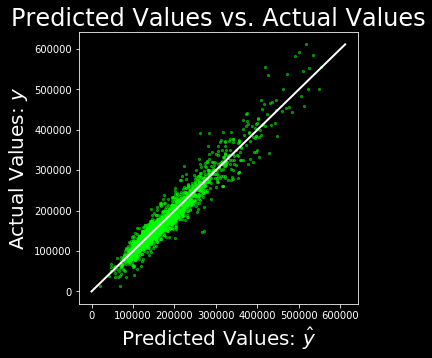

In [558]:
#Plotting 9th  LR prediction model
plt.figure(figsize=(5,5))

y_hat = np.exp(lr.predict(X))

# Generate a scatterplot of predicted values versus actual values.
plt.scatter(y_hat, new_train["saleprice"], s=5, color='lime', alpha = 0.5)

##Absolute 
sns.lineplot([0, np.max(new_train["saleprice"])], [0, np.max(new_train["saleprice"])], color="white", linewidth=2)

# Tweak title and axis labels.
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 20)
plt.ylabel("Actual Values: $y$", fontsize = 20)
plt.title('Predicted Values vs. Actual Values', fontsize = 24);

KAGGLE

In [559]:
###Interaction Terms:

In [560]:
kaggle["new_bath_beds"] = kaggle["bin_total_baths"] * kaggle["bedroom_abvgr"]
kaggle["new_bath_beds_kit"] = kaggle["new_bath_beds"] * kaggle["kitchen_abvgr"]
kaggle["new_house_age"] = kaggle["yr_sold"]  - kaggle["year_built"]
kaggle["new_age_fireplace"] = kaggle["new_house_age"] * kaggle["fireplaces"] 
kaggle["new_yr_sold_ordinal"] = kaggle["yr_sold"]  - kaggle["yr_sold"].min()
kaggle["new_yr_sold_ord_age"] = kaggle["new_yr_sold_ordinal"]  * kaggle["new_house_age"]
kaggle["new_yr_blt_remod_sold"] = (kaggle["year_built"]/kaggle["year_remod/add"]/kaggle["yr_sold"]) * 100_000
kaggle["new_lot_frontage_area_yso"]  = kaggle["lot_frontage"] * kaggle["lot_area"] * kaggle["new_yr_sold_ordinal"]

In [561]:
list(kaggle.filter(regex="new").columns)

['new_bath_beds',
 'new_bath_beds_kit',
 'new_house_age',
 'new_age_fireplace',
 'new_yr_sold_ordinal',
 'new_yr_sold_ord_age',
 'new_yr_blt_remod_sold',
 'new_lot_frontage_area_yso']

In [562]:
for cols in make_poly:
    if cols[0] in kaggle.columns and cols[1] in kaggle.columns:
        kaggle[cols[2]] = kaggle[cols[0]] * kaggle[cols[1]]

In [563]:
kaggle[new_log_field_names] = kaggle.loc[:, log_sf_fields].apply(np.log)

In [564]:
for cols in combined_features:
    if cols not in kaggle.columns:
        kaggle[cols] = 0

In [565]:
kaggle[combined_features].shape

(878, 87)

In [566]:
kaggle_preds = np.exp(lr.predict(kaggle[combined_features]))
kaggle_predictions = pd.concat((pd.DataFrame(kaggle["Id"]), pd.DataFrame(kaggle_preds, columns=["SalePrice"])), axis=1)

In [567]:
kaggle_predictions["SalePrice"].std()

82052.20906683228

In [568]:
kaggle_predictions["SalePrice"].describe()

count       878.000000
mean     180398.065112
std       82052.209067
min       50489.221314
25%      126627.062543
50%      158398.506698
75%      213659.771378
max      761680.550744
Name: SalePrice, dtype: float64

In [569]:
kaggle_predictions.to_csv("./submissions/10-features-predictions.csv", index=False)

In [591]:
##kaggle : 21072.07275